In [2]:
from ndtools import staged_max_flow as smf
from typing import Any, Dict, List, Sequence, Tuple

from pathlib import Path
import json
import matplotlib as mpl
import matplotlib.pyplot as plt

from tsum import tsum
import torch

import time

# Utility functions

For use in plotting later.

In [3]:
def relabel_selected_keys(
    selected_keys: Sequence[str],
    nodes: Dict[str, Dict[str, Any]],
    edges: Dict[str, Dict[str, Any]],
    *,
    node_label: str = "node_id",
    edge_label_fmt: str = "({from_}, {to})",
    keep_unmatched: bool = True,
) -> List[str]:
    """
    Given a list of comp_id keys (e.g., ['x1','x29',...]), return a same-length list
    where each key is replaced by:
      - node label (default: node id like 'n1') if comp_id matches a node
      - '(from,to)' if comp_id matches an edge
    First match wins if multiple components share a comp_id.
    Node takes precedence over edge if both match.
    """

    # Build comp_id -> label lookup (first match wins)
    comp_to_label: Dict[str, str] = {}

    # Nodes first (node precedence)
    for n_id, n in nodes.items():
        comp_id = n.get("comp_id")
        if comp_id and comp_id not in comp_to_label:
            # Default behaviour: label is the node key, e.g., 'n1'
            comp_to_label[comp_id] = n_id if node_label == "node_id" else str(n.get(node_label, n_id))

    # Then edges
    for _, e in edges.items():
        comp_id = e.get("comp_id")
        if comp_id and comp_id not in comp_to_label:
            comp_to_label[comp_id] = edge_label_fmt.format(from_=e.get("from"), to=e.get("to"))

    # Map list -> list (same length, order preserved)
    out_keys: List[str] = []
    for k in selected_keys:
        if k in comp_to_label:
            out_keys.append(comp_to_label[k])
        else:
            if keep_unmatched:
                out_keys.append(k)
            else:
                continue

    return out_keys

# System reliability

## Case 1: Original system

First load data.

In [4]:
DATASET = Path(r"data") 

nodes = json.loads((DATASET / "nodes.json").read_text(encoding="utf-8"))
edges = json.loads((DATASET / "edges.json").read_text(encoding="utf-8"))
probs_dict = json.loads((DATASET / "probs.json").read_text(encoding="utf-8"))


In [5]:
def s_fun(comps_st):
    flow, sys_st_str, min_comp_state = smf.sys_fun( comps_st, nodes, edges, probs_dict, target_flow = 0.5 )

    sys_st = 1 if sys_st_str == 's' else 0
    return flow, sys_st, None

row_names = list(probs_dict.keys())
n_state = 2  # binary states: 0, 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
probs = [[probs_dict[n]['0']['p'], probs_dict[n]['1']['p']] for n in row_names]
probs = torch.tensor(probs, dtype=torch.float32, device=device)

In [6]:
TSUMPATH = Path("tsum_res")

sys_surv_st = 1  # system survival state

rules_mat_surv = torch.load(TSUMPATH / f"rules_geq_{sys_surv_st}.pt", map_location="cpu")
rules_mat_surv = rules_mat_surv.to(device)
rules_mat_fail = torch.load(TSUMPATH / f"rules_leq_{sys_surv_st-1}.pt", map_location="cpu")
rules_mat_fail = rules_mat_fail.to(device)

## System marginal probability

In [7]:
st = time.time()

pr_cond = tsum.get_comp_cond_sys_prob(
    rules_mat_surv,
    rules_mat_fail,
    probs,
    comps_st_cond = {},
    row_names = row_names,
    s_fun = s_fun,
    sys_surv_st = sys_surv_st,
    n_sample = 10_000_000
)

et = time.time()
print(f"Time elapsed: {et - st:.2f} seconds\n")
print(f"P(sys >= {sys_surv_st}) = {pr_cond['survival']:.3e}")
print(f"P(sys <= {sys_surv_st-1} ) = {pr_cond['failure']:.3e}\n")

Time elapsed: 28.54 seconds

P(sys >= 1) = 8.162e-01
P(sys <= 0 ) = 1.838e-01



## Case 2: AIM

In [24]:
out_dir = Path("tsum_res_aim")
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "aims.json"

In [ ]:
sys_surv_st = 1
aim_dict = {}

#for x in probs_dict.keys():
for x in ['x46']:
    print(f"Adding component: {x}..")

    new_nodes, new_edges, new_probs = smf.add_a_component(x, nodes, edges, probs_dict)

    def s_fun(comps_st):
        flow, sys_st_str, min_comp_state = smf.sys_fun( comps_st, new_nodes, new_edges, new_probs, target_flow = 0.5 )

        sys_st = 1 if sys_st_str == 's' else 0
        return flow, sys_st, None
    
    row_names = list(new_probs.keys())
    n_state = 2  # binary states: 0, 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    probs = [[new_probs[n]['0']['p'], new_probs[n]['1']['p']] for n in row_names]
    probs = torch.tensor(probs, dtype=torch.float32, device=device)

    # load rules
    TSUMPATH = Path(rf"tsum_res_aim/{x}")

    sys_surv_st = 1  # system survival state

    rules_mat_surv = torch.load(TSUMPATH / f"rules_geq_{sys_surv_st}.pt", map_location="cpu")
    rules_mat_surv = rules_mat_surv.to(device)
    rules_mat_fail = torch.load(TSUMPATH / f"rules_leq_{sys_surv_st-1}.pt", map_location="cpu")
    rules_mat_fail = rules_mat_fail.to(device)

    # Run analysis
    st = time.time()
    pr_cond_x = tsum.get_comp_cond_sys_prob(
        rules_mat_surv,
        rules_mat_fail,
        probs,
        comps_st_cond = {},
        row_names = row_names,
        s_fun = s_fun,
        sys_surv_st = sys_surv_st,
        n_sample = 10_000_000
    )
    et = time.time()
    print(f"Time elapsed: {et - st:.2f} seconds\n")

    aim_x = max( [pr_cond['failure'] - pr_cond_x['failure'], 0] )
    aim_dict[x] = aim_x

    print(f"AIM({x}) = {aim_x:.3e}\n")

with open(out_path, "w") as f:
    json.dump(aim_dict, f, indent=4)

Adding component: x1..
Time elapsed: 27.57 seconds

AIM(x1) = 1.275e-03

Adding component: x2..
Time elapsed: 28.35 seconds

AIM(x2) = 1.200e-03

Adding component: x3..
Time elapsed: 24.93 seconds

AIM(x3) = 0.000e+00

Adding component: x4..
Time elapsed: 23.82 seconds

AIM(x4) = 0.000e+00

Adding component: x5..
Time elapsed: 27.09 seconds

AIM(x5) = 0.000e+00

Adding component: x6..
Time elapsed: 26.24 seconds

AIM(x6) = 0.000e+00

Adding component: x7..
Time elapsed: 24.90 seconds

AIM(x7) = 0.000e+00

Adding component: x8..
Time elapsed: 22.98 seconds

AIM(x8) = 0.000e+00

Adding component: x9..
Time elapsed: 22.74 seconds

AIM(x9) = 1.194e-04

Adding component: x10..
Time elapsed: 24.97 seconds

AIM(x10) = 0.000e+00

Adding component: x11..
Time elapsed: 24.18 seconds

AIM(x11) = 0.000e+00

Adding component: x12..
Time elapsed: 25.70 seconds

AIM(x12) = 0.000e+00

Adding component: x13..
Time elapsed: 24.68 seconds

AIM(x13) = 0.000e+00

Adding component: x14..
Time elapsed: 25.22

Plot the results.

In [ ]:
# Load AIM if data available from cells above
"""
aim_path = Path("tsum_res_aim") / "aims.json"

with open(aim_path, "r") as f:
    aim_dict = json.load(f)
"""

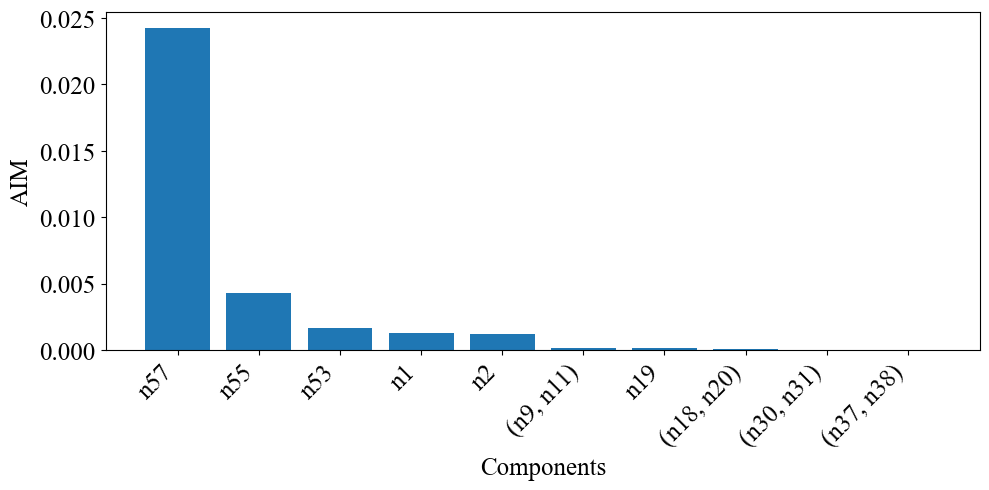

In [10]:
n_data_vis = 10 # number of components to visualise, in descending order of AIM
FONT_FAMILY = "Times New Roman"
LABEL_SIZE = 18
TICK_SIZE = 18

# Get top n_data_vis components by AIM
aims_sorted = sorted(aim_dict.items(), key=lambda item: item[1], reverse=True)
top_aims = aims_sorted[:n_data_vis]
keys, values = zip(*top_aims)

# Relabel keys for better readability
keys_rlb = relabel_selected_keys(keys, nodes, edges)

# Plot
mpl.rcParams["font.family"] = FONT_FAMILY

plt.figure(figsize=(10, 5))
plt.bar(keys_rlb, values)
plt.xlabel("Components", fontsize=LABEL_SIZE)
plt.ylabel("AIM", fontsize=LABEL_SIZE)
plt.xticks(rotation=45, ha="right", fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.tight_layout()
plt.show()

## Case 3: Deactivation Importance Measures (DIM)

In [8]:
out_dir = Path("tsum_res_dim")
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "dims.json"

In [9]:
sys_surv_st = 1
dim_dict = {}

#for x in probs_dict.keys():
for x in ['x30']:
    print(f"Deactivating component: {x}..")

    new_nodes, new_edges, new_probs = smf.deactivate_a_component(x, nodes, edges, probs_dict)

    def s_fun(comps_st):
        flow, sys_st_str, min_comp_state = smf.sys_fun( comps_st, new_nodes, new_edges, new_probs, target_flow = 0.5 )

        sys_st = 1 if sys_st_str == 's' else 0
        return flow, sys_st, None
    
    row_names = list(new_probs.keys())
    n_state = 2  # binary states: 0, 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    probs = [[new_probs[n]['0']['p'], new_probs[n]['1']['p']] for n in row_names]
    probs = torch.tensor(probs, dtype=torch.float32, device=device)

    # load rules
    TSUMPATH = Path(rf"tsum_res_dim/{x}")

    sys_surv_st = 1  # system survival state

    rules_mat_surv = torch.load(TSUMPATH / f"rules_geq_{sys_surv_st}.pt", map_location="cpu")
    rules_mat_surv = rules_mat_surv.to(device)
    rules_mat_fail = torch.load(TSUMPATH / f"rules_leq_{sys_surv_st-1}.pt", map_location="cpu")
    rules_mat_fail = rules_mat_fail.to(device)

    # Run analysis
    st = time.time()
    pr_cond_x = tsum.get_comp_cond_sys_prob(
        rules_mat_surv,
        rules_mat_fail,
        probs,
        comps_st_cond = {},
        row_names = row_names,
        s_fun = s_fun,
        sys_surv_st = sys_surv_st,
        n_sample = 10_000_000
    )
    et = time.time()
    print(f"Time elapsed: {et - st:.2f} seconds\n")

    dim_x = max( [pr_cond_x['failure'] - pr_cond['failure'], 0] )
    dim_dict[x] = dim_x

    print(f"DIM({x}) = {dim_x:.3e}\n")

"""with open(out_path, "w") as f:
    json.dump(dim_dict, f, indent=4)"""

Deactivating component: x30..


Time elapsed: 22.99 seconds

DIM(x30) = 0.000e+00



'with open(out_path, "w") as f:\n    json.dump(dim_dict, f, indent=4)'

Plot the results.

In [ ]:
# Load DIM if data available from cells above
dim_path = Path("tsum_res_dim") / "dims.json"

with open(dim_path, "r") as f:
    dim_dict = json.load(f)

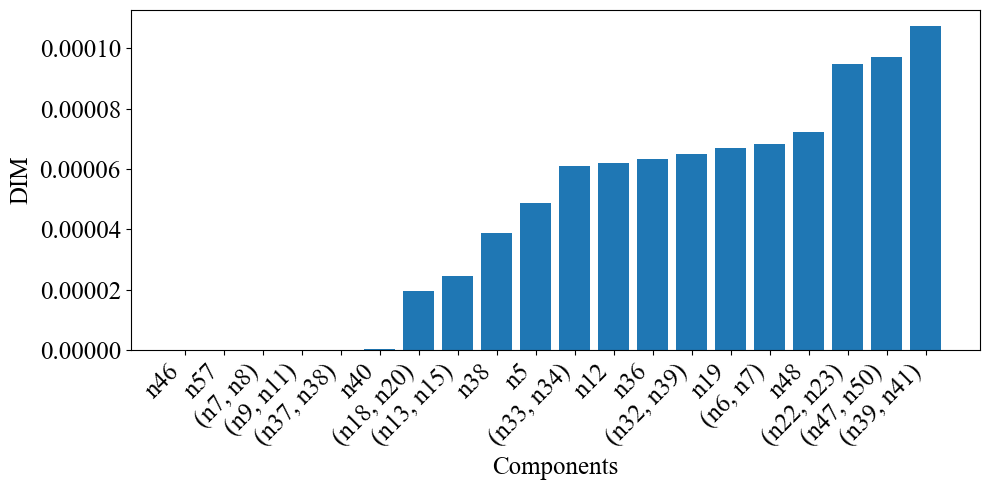

In [18]:
n_data_vis = 20 # number of components to visualise, in descending order of DIM
FONT_FAMILY = "Times New Roman"
LABEL_SIZE = 18
TICK_SIZE = 18

# Get bottom n_data_vis components by DIM
dims_sorted = sorted(dim_dict.items(), key=lambda item: item[1], reverse=False)
top_dims = dims_sorted[:n_data_vis]
keys, values = zip(*top_dims)

# Relabel keys for better readability
keys_rlb = relabel_selected_keys(keys, nodes, edges)

# Plot
mpl.rcParams["font.family"] = FONT_FAMILY

plt.figure(figsize=(10, 5))
plt.bar(keys_rlb, values)
plt.xlabel("Components", fontsize=LABEL_SIZE)
plt.ylabel("DIM", fontsize=LABEL_SIZE)
plt.xticks(rotation=45, ha="right", fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.tight_layout()
plt.show()

## Case 4: Revised system topology